In [34]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": device} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

from torch.optim import SGD

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


###########

from sklearn.metrics import r2_score, mean_squared_error

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import mpltern


%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [35]:
df = pd.read_csv("data/data_ML_1.csv") 
df.head()

,Unnamed: 0,CellNo,Condition,MAPbI3_AVAI,MAPbI3_MACl,MAPbI3,init_Voc (V),init_Jsc(mA/cm2),init_FF (%),init_PCE (%),...,init_Rshunt (ohm),fin_Voc (V),fin_Jsc(mA/cm2),fin_FF (%),fin_PCE (%),fin_Rseries (ohm),fin_Rshunt (ohm),max_PCE (%),Obj1_maxPCE,Obj2_deltaPCE
0,0,0,1,0,0,100,0.699889,3.113087,33.464061,0.729120,...,3734.279240,0.797116,4.507699,49.828753,1.790427,432.908654,10061.920900,1.928011,1.928011,0.137585
1,1,1,1,0,0,100,0.531643,2.045808,34.563001,0.375921,...,2908.016722,0.750759,4.534821,44.394810,1.511447,483.275213,6190.920236,1.586943,1.586943,0.075497
2,2,2,1,0,0,100,0.608931,1.974978,35.128460,0.422463,...,2808.222841,0.763388,4.699404,41.588095,1.491960,489.479287,4535.256618,1.584683,1.584683,0.092723
3,3,3,1,0,0,100,0.585672,1.987216,34.893906,0.406115,...,2465.048610,0.751335,4.525064,39.877689,1.355777,540.330779,4064.174483,1.435199,1.435199,0.079422
4,4,4,2,0,20,80,0.559362,2.049479,34.588400,0.396522,...,2363.234925,0.763785,3.927000,39.999547,1.199739,628.369510,4618.812120,1.346479,1.346479,0.146740


In [36]:
# train_x, volume ratio, already normalized
train_x = torch.tensor((df[['MAPbI3_AVAI','MAPbI3_MACl','MAPbI3']]/100).to_numpy(), **tkwargs)
train_x

tensor([[0.000, 0.000, 1.000],
        [0.000, 0.000, 1.000],
        [0.000, 0.000, 1.000],
        [0.000, 0.000, 1.000],
        [0.000, 0.200, 0.800],
        [0.000, 0.200, 0.800],
        [0.000, 0.200, 0.800],
        [0.000, 0.200, 0.800],
        [0.000, 0.400, 0.600],
        [0.000, 0.400, 0.600],
        [0.000, 0.400, 0.600],
        [0.000, 0.600, 0.400],
        [0.000, 0.600, 0.400],
        [0.000, 0.600, 0.400],
        [0.000, 0.600, 0.400],
        [0.000, 0.800, 0.200],
        [0.000, 0.800, 0.200],
        [0.000, 0.800, 0.200],
        [0.000, 0.800, 0.200],
        [0.000, 1.000, 0.000],
        [0.000, 1.000, 0.000],
        [0.000, 1.000, 0.000],
        [0.000, 1.000, 0.000],
        [0.200, 0.000, 0.800],
        [0.200, 0.000, 0.800],
        [0.200, 0.200, 0.600],
        [0.200, 0.200, 0.600],
        [0.200, 0.200, 0.600],
        [0.200, 0.200, 0.600],
        [0.200, 0.400, 0.400],
        [0.200, 0.400, 0.400],
        [0.200, 0.600, 0.200],
        

In [37]:
# train_obj, maximize peak PCE & minimize delta PCE

train_obj_np = df[['Obj1_maxPCE','Obj2_deltaPCE']].to_numpy()
train_obj = torch.tensor(train_obj_np, **tkwargs)

obj1max = train_obj.max(axis=0).values
obj1min = train_obj.min(axis=0).values
#train_obj = train_obj / (train_obj.max(axis=0).values - train_obj.min(axis=0).values).view(1, 2)
train_obj = train_obj / (train_obj.max(axis=0).values).view(1, 2)
train_obj[:,1] = -train_obj[:,1]

train_obj 

tensor([[ 0.189, -0.042],
        [ 0.155, -0.023],
        [ 0.155, -0.028],
        [ 0.140, -0.024],
        [ 0.132, -0.045],
        [ 0.130, -0.035],
        [ 0.130, -0.044],
        [ 0.126, -0.045],
        [ 0.158, -0.153],
        [ 0.107, -0.097],
        [ 0.114, -0.073],
        [ 0.116, -0.066],
        [ 0.097, -0.070],
        [ 0.093, -0.077],
        [ 0.111, -0.068],
        [ 0.087, -0.096],
        [ 0.096, -0.014],
        [ 0.156, -0.146],
        [ 0.130, -0.032],
        [ 0.137, -0.012],
        [ 0.183, -0.000],
        [ 0.157, -0.000],
        [ 0.144, -0.005],
        [ 0.938, -0.947],
        [ 0.939, -1.000],
        [ 0.925, -0.447],
        [ 0.963, -0.231],
        [ 1.000, -0.190],
        [ 0.990, -0.267],
        [ 0.950, -0.245],
        [ 0.974, -0.209],
        [ 0.970, -0.166],
        [ 0.975, -0.191],
        [ 0.898, -0.328],
        [ 0.897, -0.271],
        [ 0.898, -0.227],
        [ 0.940, -0.125],
        [ 0.794, -0.252],
        [ 0.

In [38]:
obj2maxval = obj1max[1].item()
obj2maxval

3.253627818

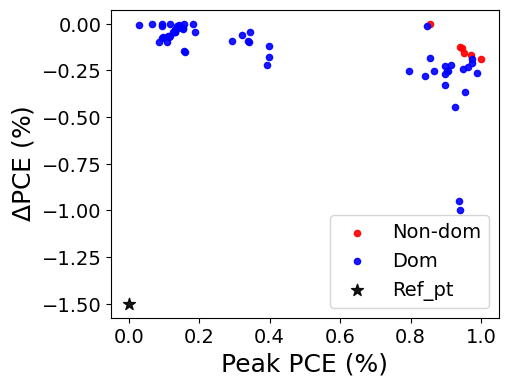

In [39]:
# normalized objectives plot. include a preset ref_pt for qNEHVI

fig, ax = plt.subplots(ncols = 1, figsize = (5,4))

pf_mask = is_non_dominated(train_obj)
ref_point = torch.tensor([0, -1.5], **tkwargs)

ax.scatter(train_obj[:, 0][pf_mask].cpu().numpy(), train_obj[:, 1][pf_mask].cpu().numpy(),
               c='r', s=20, alpha=0.9, label='Non-dom')

ax.scatter(train_obj[:, 0][~pf_mask].cpu().numpy(), train_obj[:, 1][~pf_mask].cpu().numpy(),
               c='b', s=20, alpha=0.9, label='Dom')

ax.scatter(ref_point[0].cpu().numpy(), ref_point[1].cpu().numpy(),
               c='k', marker='*', s=80, alpha=0.9, label='Ref_pt')

ax.set(xlabel='Peak PCE (%)', ylabel='$\Delta$PCE (%)')

ax.legend()

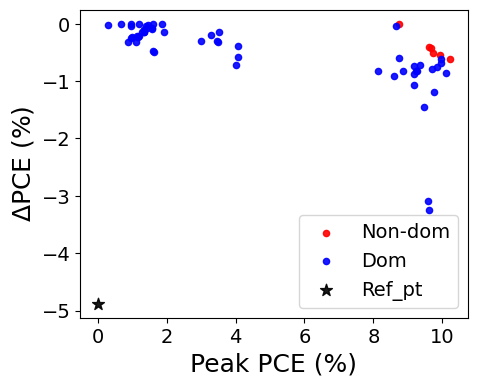

In [40]:
# real objective plot
norm_devider = obj1max
train_obj_real = train_obj*norm_devider # train_obj_real contain the real value


fig, ax = plt.subplots(ncols = 1, figsize = (5,4))

pf_mask = is_non_dominated(train_obj)
ref_point = torch.tensor([0, (-1.5*obj2maxval)], **tkwargs) # -1.5 is reference point in normalized space

ax.scatter(train_obj_real[:, 0][pf_mask].cpu().numpy(), train_obj_real[:, 1][pf_mask].cpu().numpy(),
               c='r', s=20, alpha=0.9, label='Non-dom')

ax.scatter(train_obj_real[:, 0][~pf_mask].cpu().numpy(), train_obj_real[:, 1][~pf_mask].cpu().numpy(),
               c='b', s=20, alpha=0.9, label='Dom')

ax.scatter(ref_point[0].cpu().numpy(), ref_point[1].cpu().numpy(),
               c='k', marker='*', s=80, alpha=0.9, label='Ref_pt')

ax.set(xlabel='Peak PCE (%)', ylabel='$\Delta$PCE (%)')

ax.legend()

In [41]:
pf_mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False, False,  True, False, False, False,
        False, False,  True, False, False, False, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False])

In [42]:
random_state = 1
n_var, n_obj = 3, 2

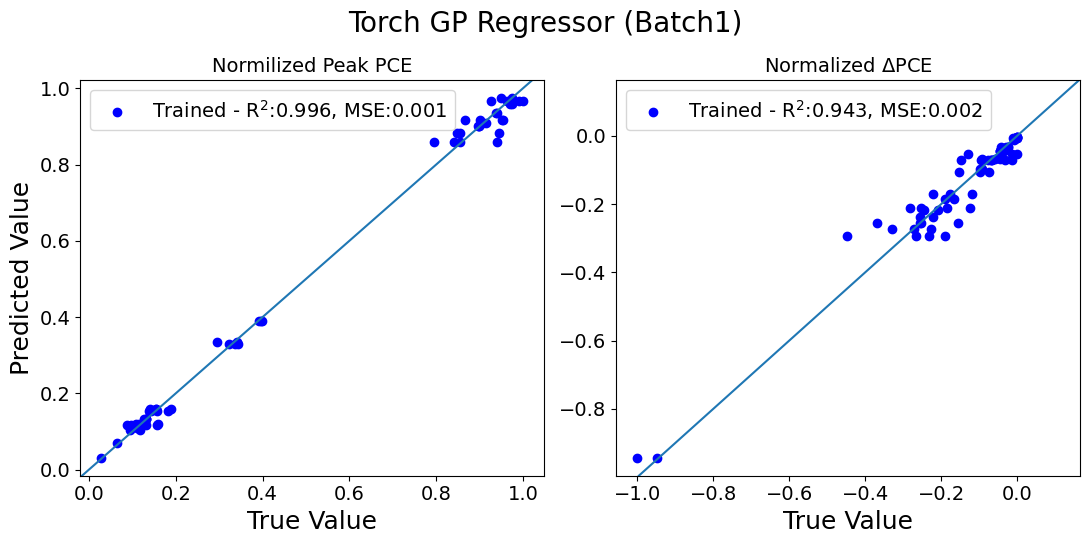

In [43]:
# as a means of prediction -  train a simple GP model, plot a y-y plot

models = []
for i in range(train_obj.shape[-1]):
    models.append(SingleTaskGP(train_x, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_model(mll) 

model.eval()

with torch.no_grad():
    y_true = train_obj
    y_pred = model.posterior(train_x)  .mean.squeeze()
    #y_cand = model.posterior(nsga_candidates).mean.squeeze()
    

fig, ax = plt.subplots(ncols = 2, figsize = (11,5.5))

for i, obj in zip([0,1], ["Normilized Peak PCE", 'Normalized $\Delta$PCE']):

        ax[i].axline((0.11, 0.11), slope=1)
        
        r2score = r2_score(train_obj[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        msescore = mean_squared_error(train_obj[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        
        ax[i].scatter(x=y_true[...,i].cpu().numpy(), y=y_pred[...,i].cpu().numpy(),
                      label=f"Trained - R$^2$:{r2score:0.3f}, MSE:{msescore:0.3f}", c='b'
                       )
        #ax[i].scatter(x=y_cand[...,i].cpu().numpy(), y=y_cand[...,i].cpu().numpy(),
        #      c='m', label='Predicted EA candidates'
        #       )
        
        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')
        ax[i].legend()
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('Torch GP Regressor (Batch1)')
fig.tight_layout()

In [44]:
#predict 6 candidates for Batch 2 using BO

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

# define the acqusition function
acq_func = qNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

'''
sobol_candidates = draw_sobol_samples(bounds=standard_bounds,n=256, q=1).squeeze(1)
sobol_candidates = sobol_candidates/sobol_candidates.sum(axis=1).unsqueeze(1)

acq_list = []
for i in range(0, sobol_candidates.shape[0]):
    with torch.no_grad():
        acq_value = acq_func(sobol_candidates[i].unsqueeze(dim=0))
        acq_list.append(acq_value.item())
'''
        
# propose candidates given defined qNEHVI acq func given model and latest observed training data
new_x, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds,
                q=6, # no of candidates to propose in parallel
                num_restarts=2, #the higher, the more like the graph 
                raw_samples=128,
                options={"batch_limit": 5, "maxiter": 200},
                )

new_x

tensor([[0.278, 0.457, 0.467],
        [0.282, 0.642, 0.602],
        [0.316, 0.566, 1.000],
        [0.302, 0.959, 0.430],
        [0.272, 0.044, 0.047],
        [0.254, 1.000, 0.853]], dtype=torch.float64)

In [45]:
# Freezed. Candidates used for batch 2 experiment
used_candidates = torch.tensor([[0.286, 0.746, 0.696],
                              [0.347, 0.812, 0.000],
                              [0.274, 0.163, 0.022],
                              [0.285, 0.792, 0.807],
                              [0.297, 0.663, 0.283],
                              [0.274, 0.049, 0.000]], dtype=torch.float64)
new_x = used_candidates  

print(new_x)

tensor([[0.286, 0.746, 0.696],
        [0.347, 0.812, 0.000],
        [0.274, 0.163, 0.022],
        [0.285, 0.792, 0.807],
        [0.297, 0.663, 0.283],
        [0.274, 0.049, 0.000]], dtype=torch.float64)


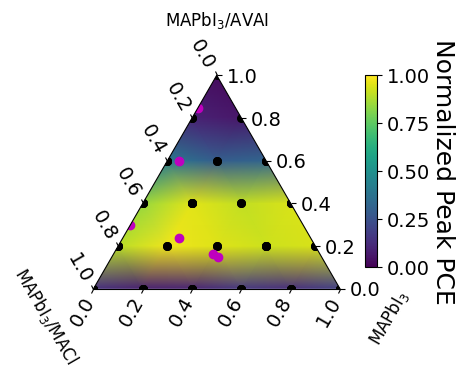

In [46]:
# check new candidates' positions on ternary plot


fig = plt.figure(figsize=(7, 4))

ax = fig.add_subplot(1, 2, 1, projection="ternary")

tpc = ax.tripcolor(train_x[:,0].cpu().numpy(),
             train_x[:,1].cpu().numpy(),
             train_x[:,2].cpu().numpy(),
             y_true[:,0].cpu().numpy(), 
             shading='gouraud', 
             rasterized=True,
             vmin = 0
          )

ax.scatter(train_x[:,0].cpu().numpy(),
           train_x[:,1].cpu().numpy(),
           train_x[:,2].cpu().numpy(),
           c='k',
           marker = 'o',
           edgecolors = 'black',#vmin=vmin, vmax=vmax
           s = 30 
          )

ax.scatter(new_x[:,0].cpu().numpy(),
           new_x[:,1].cpu().numpy(),
           new_x[:,2].cpu().numpy(),
           c='m', #cmap='magma',#vmin=vmin, vmax=vmax
          )

            
cax = ax.inset_axes([1.1, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar=fig.colorbar(tpc, cax = cax)
colorbar.set_label('Normalized Peak PCE', rotation=270, va='baseline')
ax.set_tlabel("MAPbI$_3$/AVAI",fontsize=12)
ax.set_llabel("MAPbI$_3$/MACl",fontsize=12)
ax.set_rlabel("MAPbI$_3$",fontsize=12)
#ax.set_title(param)
plt.show()
#ax.set_title('Peak PCE w/ BO candidates')


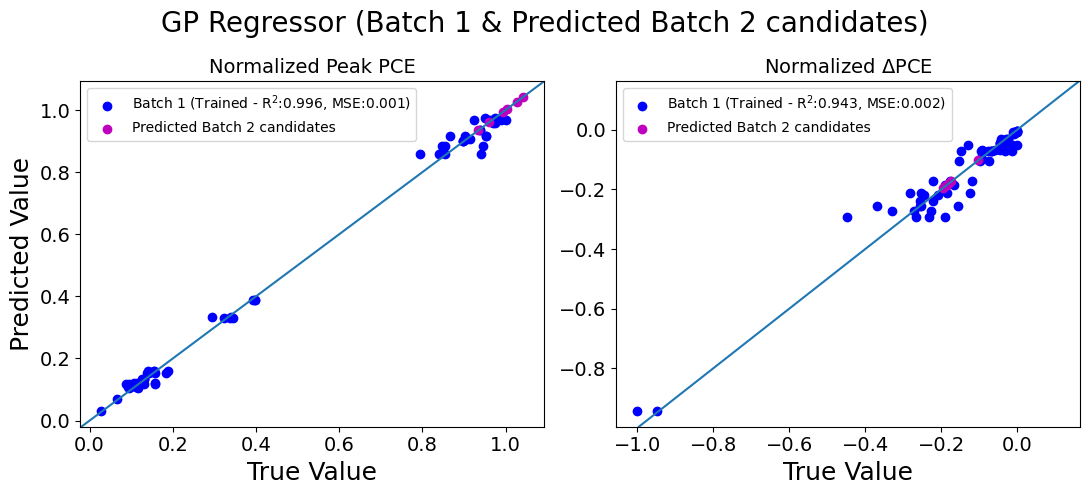

In [47]:
# prediction of batch 2 achievement

models = []
for i in range(train_obj.shape[-1]):
    models.append(SingleTaskGP(train_x, train_obj[..., i : i + 1], outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_model(mll) 

model.eval()

with torch.no_grad():
    y_true = train_obj
    y_pred = model.posterior(train_x)  .mean.squeeze()
    y_cand = model.posterior(new_x).mean.squeeze()
    

fig, ax = plt.subplots(ncols = 2, figsize = (11,5))

for i, obj in zip([0,1], ["Normalized Peak PCE", 'Normalized $\Delta$PCE']):

        ax[i].axline((0.11, 0.11), slope=1)
        
        r2score = r2_score(train_obj[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        msescore = mean_squared_error(train_obj[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        
        ax[i].scatter(x=y_true[...,i].cpu().numpy(), y=y_pred[...,i].cpu().numpy(),
                      label=f"Batch 1 (Trained - R$^2$:{r2score:0.3f}, MSE:{msescore:0.3f})", c='b'
                       )
        ax[i].scatter(x=y_cand[...,i].cpu().numpy(), y=y_cand[...,i].cpu().numpy(),
              c='m', label='Predicted Batch 2 candidates'
               )
        
        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')
        ax[i].legend(loc='upper left',fontsize=10)
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('GP Regressor (Batch 1 & Predicted Batch 2 candidates)')
fig.tight_layout()

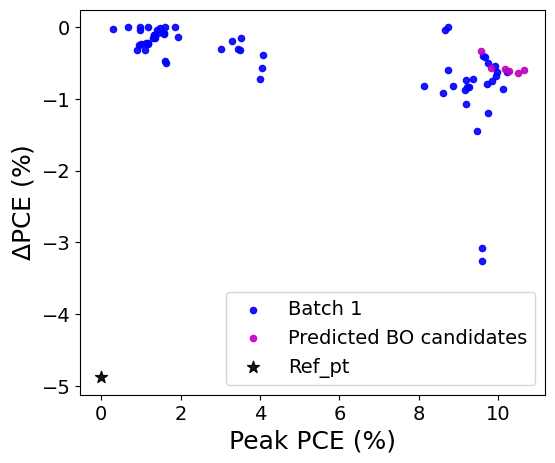

In [48]:
# prediction of batch 2 achievement

train_obj_real = train_obj * norm_devider
y_cand_real = y_cand * norm_devider


ref_point = torch.tensor([0, -1.5*obj2maxval], **tkwargs)

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

ax.scatter(train_obj_real[:, 0].cpu().numpy(), train_obj_real[:, 1].cpu().numpy(),
               c='b', s=20, alpha=0.9, label='Batch 1')

ax.scatter(y_cand_real[:, 0].cpu().numpy(), y_cand_real[:, 1].cpu().numpy(),
               c='m', s=20, alpha=0.9, label='Predicted BO candidates')
               
ax.scatter(ref_point[0].cpu().numpy(), ref_point[1].cpu().numpy(),
               c='k', marker='*', s=80, alpha=0.9, label='Ref_pt')


ax.set(xlabel='Peak PCE (%)', ylabel='$\Delta$PCE (%)')

ax.legend()

In [51]:
#new candidates (Batch 2) volume ratio (total volume = 100 ul)

df_new = pd.DataFrame(new_x.numpy(), columns=['MAPbI3_AVAI', 'MAPbI3_MACl', 'MAPbI3'])
# Normalize each value
df_new = df_new.div(df_new.sum(axis=1), axis=0).mul(100)
df_new

,MAPbI3_AVAI,MAPbI3_MACl,MAPbI3
0,16.550926,43.171296,40.277778
1,29.939603,70.060397,0.000000
2,59.694989,35.511983,4.793028
3,15.127389,42.038217,42.834395
4,23.893805,53.338697,22.767498
5,84.829721,15.170279,0.000000
